### Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

### Loading Dataset

In [27]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [31]:
train_images.shape

(60000, 28, 28)

In [32]:
train_labels.shape

(60000,)

## Performing Image Augmentation - Part 1

### Data Visualization

In [5]:
def display_images(images):
  fig = plt.figure(figsize=(50, 50))
  row = 1
  columns = len(images)
  for i in range(len(images)):
    image = images[i].reshape(28, 28)
    fig.add_subplot(row, columns, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis("off")

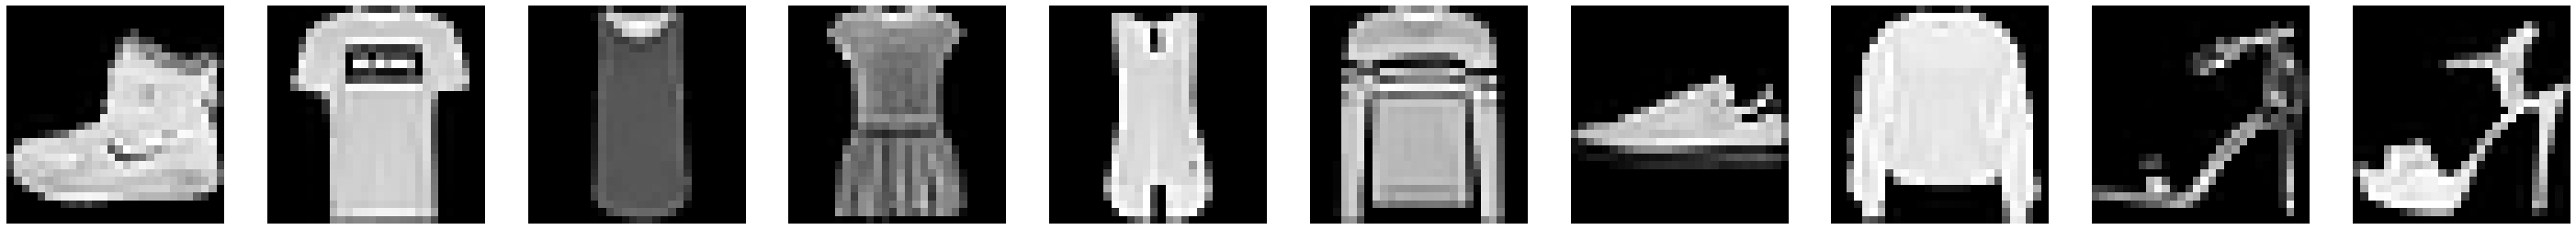

In [6]:
display_images(train_images[:10])

### Rotation

In [7]:
def rotate_by(image, angle=45):
  ht, wt = image.shape[:2]
  rotation_matrix = cv2.getRotationMatrix2D((wt/2, ht/2), angle, .5)
  rotated_image = cv2.warpAffine(image, rotation_matrix, (wt, ht))
  rotated_image = rotated_image.reshape(1, 28, 28)
  return rotated_image

In [8]:
def augment_rotation(X, y, size, n=10):
  generated_images = []
  for i in range(n):
    random_idx = random.randint(0, size)
    rotated_img = rotate_by(train_images[random_idx], angle=i*45)
    label = y[random_idx]
    label = label.reshape(1,)
    generated_images.append(rotated_img)
    X = np.append(X, rotated_img, axis=0)
    y = np.append(y, label, axis=0)
    
  return X, y, generated_images

X_augment, y_augment, generated_images = augment_rotation(train_images, train_labels, train_images.shape[0])
print(X_augment.shape)
print(y_augment.shape)

(60010, 28, 28)
(60010,)


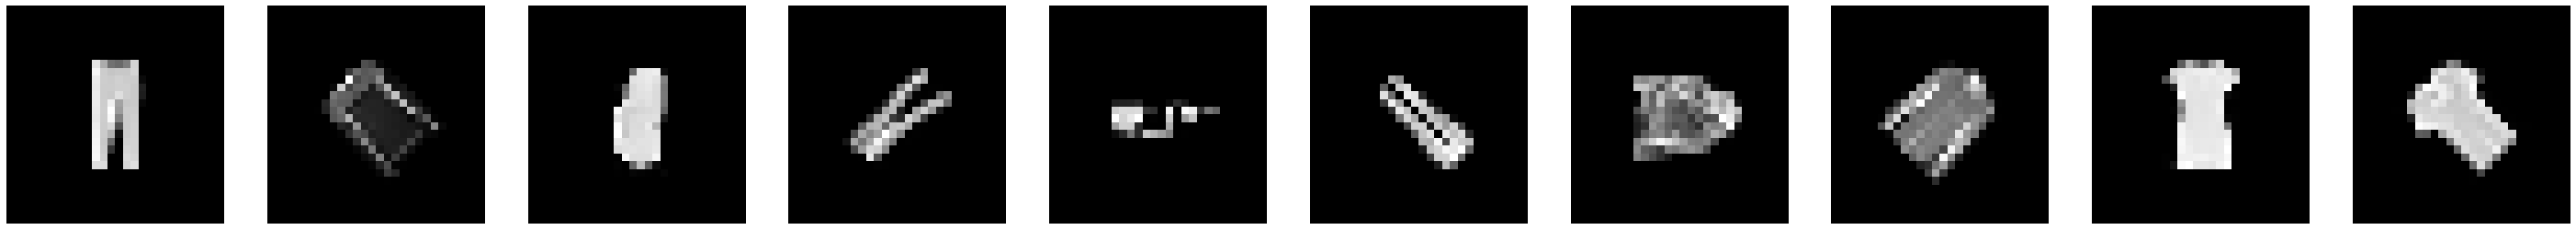

In [9]:
display_images(generated_images)

### Flipping

In [10]:
def flip(image, vertical=True, horizontal=False):
  if horizontal:
    img =  cv2.flip(image, 1)
  elif vertical:
    img = cv2.flip(image, 0)
  img = img.reshape(1, 28, 28)
  return img

In [11]:
def augment_flip(X, y, size, n=10):
  generated_images = []
  for i in range(n):
    random_idx = random.randint(0, size)
    flipped_img = flip(train_images[random_idx])
    label = y[random_idx]
    label = label.reshape(1,)
    generated_images.append(flipped_img)
    X = np.append(X, flipped_img, axis=0)
    y = np.append(y, label, axis=0)
    
  return X, y, generated_images

X_augment, y_augment, generated_images = augment_flip(X_augment, y_augment, train_images.shape[0])
print(X_augment.shape)
print(y_augment.shape)

(60020, 28, 28)
(60020,)


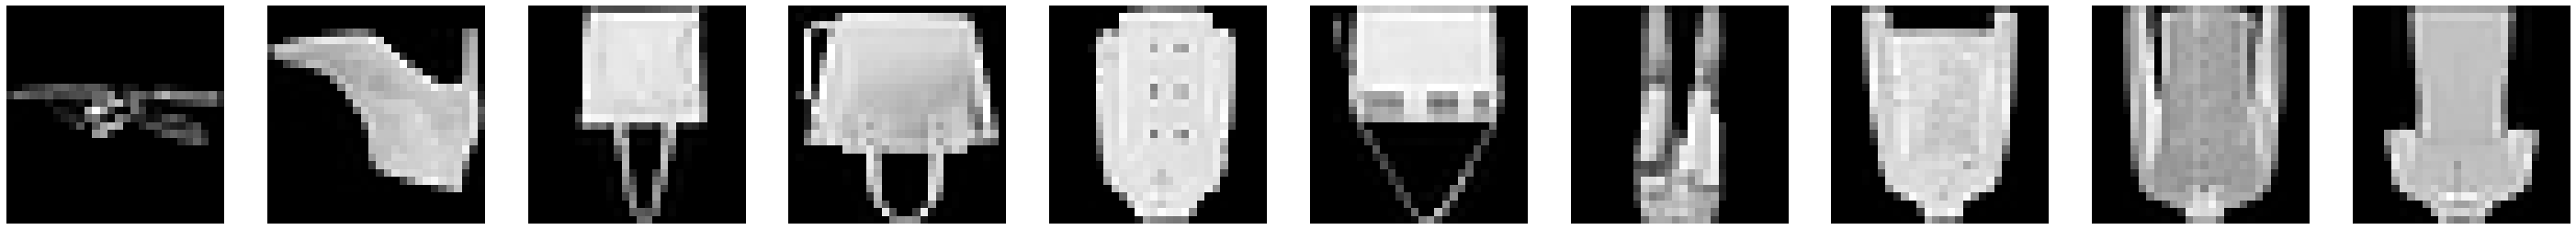

In [12]:
display_images(generated_images)

### Quadratic Intensity Scaling

In [13]:
def intensity_scaling(image, gamma=2):
  image_corrected = np.array(255*(image/255)**gamma)
  image_corrected = image_corrected.reshape(1, 28, 28)
  return image_corrected

In [14]:
def intensity_correction(X, y, size, n=10):
  generated_image = []
  for i in range(n):
    random_idx = random.randint(0, size)
    intensity_scaled_image = intensity_scaling(train_images[random_idx])
    label = y[random_idx]
    label = label.reshape(1,)
    generated_image.append(intensity_scaled_image)
    X = np.append(X, intensity_scaled_image, axis=0)
    y = np.append(y, label, axis=0)
    
  return X, y, generated_image

X_augment, y_augment, generated_image = intensity_correction(X_augment, y_augment, train_images.shape[0])
print(X_augment.shape)
print(y_augment.shape)

(60030, 28, 28)
(60030,)


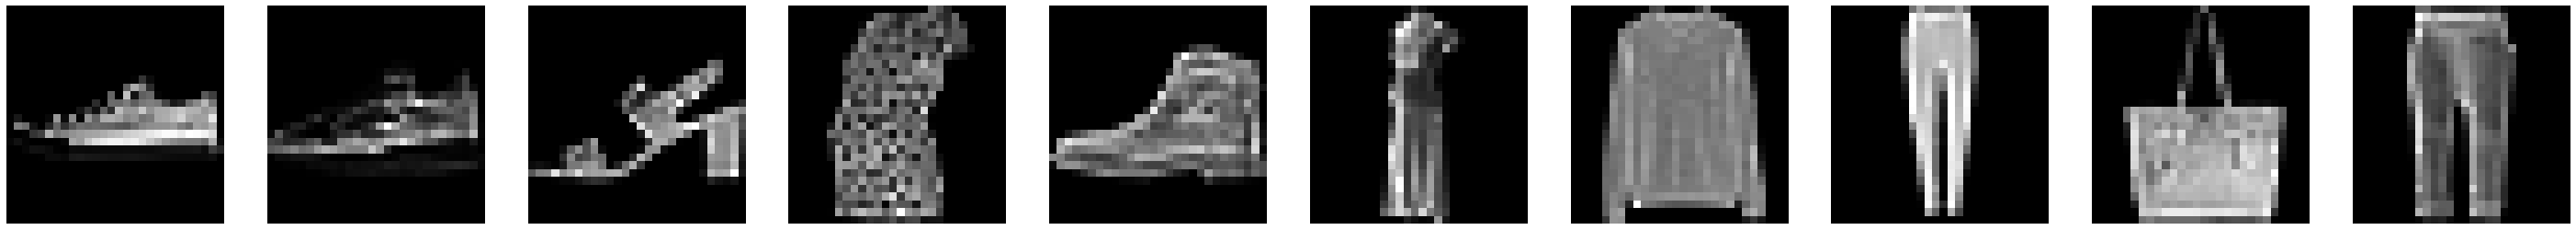

In [15]:
display_images(generated_image)

## Building Model - Part 2

### Setup the Layers

In [33]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compiling the model

In [34]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model 

In [41]:
model.fit(train_images, train_labels, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 289us/sample - loss: 0.4241 - accuracy: 0.8590
Epoch 2/5
60000/60000 [==============================] - 21s 351us/sample - loss: 0.4205 - accuracy: 0.8608
Epoch 3/5
60000/60000 [==============================] - 33s 543us/sample - loss: 0.4137 - accuracy: 0.8607
Epoch 4/5
60000/60000 [==============================] - 29s 489us/sample - loss: 0.4224 - accuracy: 0.8608 27s - loss: 0.4036 - accu - ETA: 28s - loss: 0.3995
Epoch 5/5
60000/60000 [==============================] - 18s 298us/sample - loss: 0.4178 - accuracy: 0.8603


### Checking the accuracy on test dataset

In [42]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

10000/10000 [==============================] - 3s 253us/sample - loss: 0.5094 - accuracy: 0.8464
Test loss: 0.5094128270626068
Test accuracy: 0.8464


## Modify the above architecture by using Batch normalisation, dropout, ReduceLRonPlateau, Early stopping - Part 3


### Setup the Layers

In [43]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compiling the model

In [44]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Setting Parameters

In [53]:
earlystopping = EarlyStopping(patience = 7, monitor='val_loss')
reduce_LR_plateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4)

### Running Model

In [52]:
history = model.fit(train_images, train_labels, validation_data = (test_images, test_labels),
                    epochs=5, batch_size=256, callbacks=[earlystopping, reduce_LR_plateau],
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.3068 - accuracy: 0.8906 - val_loss: 0.4638 - val_accuracy: 0.8582
Epoch 2/5
60000/60000 [==============================] - 5s 75us/sample - loss: 0.3039 - accuracy: 0.8919 - val_loss: 0.4596 - val_accuracy: 0.8592
Epoch 3/5
60000/60000 [==============================] - 4s 69us/sample - loss: 0.3035 - accuracy: 0.8920 - val_loss: 0.4592 - val_accuracy: 0.8571
Epoch 4/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.3032 - accuracy: 0.8919 - val_loss: 0.4591 - val_accuracy: 0.8565
Epoch 5/5
60000/60000 [==============================] - 7s 118us/sample - loss: 0.3027 - accuracy: 0.8927 - val_loss: 0.4606 - val_accuracy: 0.8572


## Difference Between Performances of the model in part-2 and part-3

### The difference between the accuracy of the models in part-2 and part-3 is a lot higher. From the above, we can conclude that for this case, the model performs better after implementing Batch Normalisation, ReduceLRonPlateau, Early stopping.

# Thank You